# Project 1: High School Social Network Analysis

##### Jimmy Ng & Corey Arnouts

## Overview

For this project, we are going to look at the interactions between students at a high school in France. This dataset includes categorical data about the genders of the students. The data is extracted from the website **sociopatterns.org**.

http://www.sociopatterns.org/datasets/high-school-dynamic-contact-networks/

## Import data

In [1]:
import networkx as nx
from nxviz import CircosPlot
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import count
import warnings

warnings.filterwarnings('ignore')

df2011 = pd.read_csv('https://raw.githubusercontent.com/myvioletrose/data620_team/master/assignment/week_4/high-school-social-network2012.txt',
                 sep='\t',
                 header=None,
                 names=['t', 'i', 'j','Ci','Cj'])

attributes2011 = pd.read_csv('https://raw.githubusercontent.com/myvioletrose/data620_team/master/project/project_1/node2011.csv',
                            delimiter = ',')


Bad key "text.kerning_factor" on line 4 in
C:\Users\myvio\Anaconda3\envs\sps620env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Plan for analysis

First, we simplify the dataset by summing up the frequency of communication between students. We will use it ('freq') as 'weight'. We generate our edge and node sets for building an **undirected** graph. Subsequently, we will visualize the overall social network before moving on to calculate **neighbors** and different **centrality** meausures. We will compare the differences between male and female. In addition, we will find and return all possible **cliques** in this exercise. Lastly, we will visualize the shortest path between the most and least popular students.

## Edge, Node Sets

In [2]:
# edge2011
edge2011 = df2011.loc[:,'t':'j'].groupby(['i', 'j']).count().reset_index()
edge2011.columns = ['student_id1', 'student_id2', 'freq']

# node2011
node2011 = attributes2011.loc[:, ['node', 'gender']]

In [3]:
edge2011

,student_id1,student_id2,freq
0,600,609,53
1,600,610,20
2,600,613,567
3,600,616,1
4,600,623,4
...,...,...,...
2234,1674,1686,8
2235,1674,1856,1
2236,1678,1679,1
2237,1679,1686,2


In [4]:
node2011

,node,gender
0,600,F
1,601,M
2,602,M
3,603,F
4,605,F
...,...,...
175,1674,M
176,1678,M
177,1679,M
178,1686,F


In [5]:
edge2011.shape

(2239, 3)

In [6]:
node2011.shape

(180, 2)

## Undirected Graph

In [7]:
# undirected graph
undirected_G = nx.Graph()

# adding edges to graph 
for idx in edge2011.index:    
    p1 = edge2011.loc[idx]['student_id1']
    p2 = edge2011.loc[idx]['student_id2']
    w = edge2011.loc[idx]['freq']
    undirected_G.add_edge(p1, p2, weight = w)    

# add node attribute
for node in undirected_G.nodes:    
    undirected_G.node[node]['gender'] = node2011.loc[node2011['node'] == node, 'gender'].item()

In [8]:
list(undirected_G.nodes(data = True))[:5]

[(600, {'gender': 'F'}),
 (609, {'gender': 'F'}),
 (610, {'gender': 'M'}),
 (613, {'gender': 'F'}),
 (616, {'gender': 'F'})]

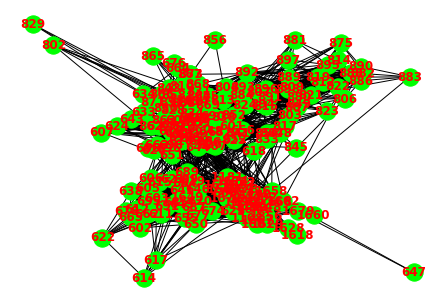

In [9]:
nx.draw(undirected_G, with_labels = True, font_weight = 'bold', node_color = "lime", font_color = "red")    

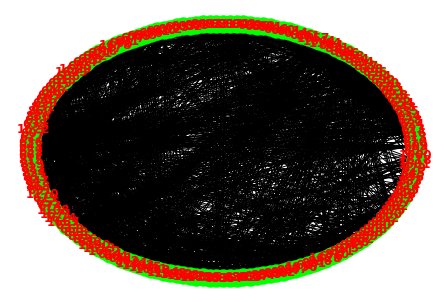

In [10]:
nx.draw_shell(undirected_G, with_labels = True, font_weight = 'bold', node_color = "lime", font_color = "red")    

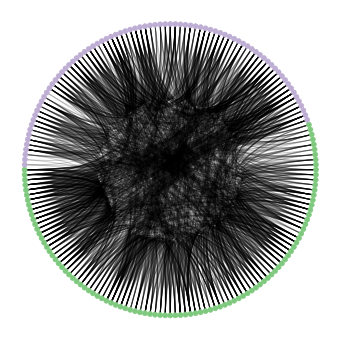

In [11]:
c = CircosPlot(undirected_G, node_color = 'gender', node_grouping = 'gender')
c.draw()

## Neighbors

Counting a number of neighbors (nodes) associated with a node is an important first step to evaluate its significance in a graph. We can consider it as a popularity measure for each student. 

In [12]:
node_to_neighbors_mapping = [(node, len(list(undirected_G.neighbors(node)))) for node in undirected_G.nodes()]

node_to_neighbors_ser = pd.Series(data = dict(node_to_neighbors_mapping))

node_to_neighbors_ser.sort_values(ascending = False).head()

826    56
683    50
620    48
860    47
641    47
dtype: int64

In [13]:
n = node_to_neighbors_ser.sort_values(ascending = False).to_frame()
n.reset_index(inplace = True)
n.columns = ['node', 'neighbors']

In [14]:
most_popular_student = n.head(1).iloc[0,0]
least_popular_student = n.tail(1).iloc[0,0]
print(f'The most popular student in school in terms of number of connection is student \'{most_popular_student}\', whereas the least popular student is \'{least_popular_student}\'')

The most popular student in school in terms of number of connection is student '826', whereas the least popular student is '856'


In [15]:
node2011 = node2011.merge(n, on = 'node').sort_values(by = ['neighbors'], ascending = False)

In [16]:
node2011.groupby('gender')['neighbors'].mean()

gender
F    24.980
M    24.275
Name: neighbors, dtype: float64

## Degree Centrality 

In [17]:
sorted(nx.degree_centrality(undirected_G).items(), key = lambda x : x[1], reverse = True)[:5]

[(826, 0.3128491620111732),
 (683, 0.27932960893854747),
 (620, 0.2681564245810056),
 (641, 0.26256983240223464),
 (860, 0.26256983240223464)]

In [18]:
d = pd.DataFrame.from_dict(nx.degree_centrality(undirected_G), 
                           orient = 'index')
d.reset_index(inplace = True)
d.columns = ['node', 'degree_centrality']

In [19]:
node2011 = node2011.merge(d, on = 'node')

In [20]:
node2011.groupby('gender')['degree_centrality'].mean()

gender
F    0.139553
M    0.135615
Name: degree_centrality, dtype: float64

## Eigenvector Centrality

In [21]:
sorted(nx.eigenvector_centrality(undirected_G).items(), key = lambda x : x[1], reverse = True)[:5]

[(683, 0.15726929795547476),
 (826, 0.14349601587250657),
 (681, 0.13819175842299414),
 (1657, 0.1322500766452872),
 (661, 0.1318970662996578)]

In [22]:
e = pd.DataFrame.from_dict(nx.eigenvector_centrality(undirected_G),                            
                           orient = 'index')
e.reset_index(inplace = True)
e.columns = ['node', 'eigenvector_centrality']

In [23]:
node2011 = node2011.merge(e, on = 'node')

In [24]:
node2011.groupby('gender')['eigenvector_centrality'].mean()

gender
F    0.065611
M    0.065928
Name: eigenvector_centrality, dtype: float64

## Betweenness Centrality

In [25]:
sorted(nx.betweenness_centrality(undirected_G).items(), key = lambda x : x[1], reverse = True)[:5]

[(826, 0.05891680646992869),
 (620, 0.029566243348582096),
 (860, 0.028671166037344615),
 (641, 0.026672797961426867),
 (1657, 0.025820225297560423)]

In [26]:
b = pd.DataFrame.from_dict(nx.eigenvector_centrality(undirected_G),                            
                           orient = 'index')
b.reset_index(inplace = True)
b.columns = ['node', 'betweenness_centrality']

In [27]:
node2011 = node2011.merge(b, on = 'node')

In [28]:
node2011.groupby('gender')['betweenness_centrality'].mean()

gender
F    0.065611
M    0.065928
Name: betweenness_centrality, dtype: float64

## Node Table Summary

In this exercise, there is no considerable difference between genders from the above measures. 

In [29]:
node2011.sort_values(by = ['neighbors'], ascending = False)

,node,gender,neighbors,degree_centrality,eigenvector_centrality,betweenness_centrality
0,826,M,56,0.312849,0.143496,0.143496
1,683,M,50,0.279330,0.157269,0.157269
2,620,F,48,0.268156,0.126903,0.126903
4,641,F,47,0.262570,0.113162,0.113162
3,860,F,47,0.262570,0.106850,0.106850
...,...,...,...,...,...,...
175,865,F,5,0.027933,0.009636,0.009636
176,845,F,4,0.022346,0.009532,0.009532
177,829,M,3,0.016760,0.005725,0.005725
178,647,M,2,0.011173,0.004592,0.004592


## Cliques

Let's look at number and size of cliques formed in this high school network.

In [30]:
cliques = list(nx.find_cliques(undirected_G))
print('there is {x} number of cliques in this network'.format(x = len(cliques)))

there is 1742 number of cliques in this network


In [31]:
cliques

[[1601, 1658, 1190, 1613, 1856, 1644, 1144, 1170, 1657],
 [1601, 1658, 1190, 1613, 1856, 1644, 1144, 1170, 1148],
 [1601, 1658, 1190, 1613, 1856, 1644, 1144, 1629],
 [1601, 1658, 1190, 1613, 1678, 1170, 1657],
 [1601, 1658, 1190, 1613, 1678, 1170, 1148],
 [1601, 1658, 1190, 1613, 1678, 1629],
 [1601, 1667, 1618, 1678, 1108, 1628, 1657],
 [1601, 1667, 1618, 1678, 1108, 1628, 1629],
 [1601, 1667, 1613, 1856, 1644, 1628, 1629, 1108],
 [1601, 1667, 1613, 1856, 1644, 1628, 1645, 1657, 1170],
 [1601, 1667, 1613, 1856, 1644, 1628, 1645, 1657, 1108],
 [1601, 1667, 1613, 1856, 1644, 1190, 1144, 1629, 1108],
 [1601, 1667, 1613, 1856, 1644, 1190, 1144, 1645, 1657, 1170],
 [1601, 1667, 1613, 1856, 1644, 1190, 1144, 1645, 1657, 1108],
 [1601, 1667, 1613, 1856, 1644, 1190, 1144, 1645, 1148, 1170],
 [1601, 1667, 1613, 1856, 1644, 1190, 1144, 1645, 1148, 1108],
 [1601, 1667, 1613, 1678, 1628, 1629, 1108],
 [1601, 1667, 1613, 1678, 1628, 1645, 1657, 1170],
 [1601, 1667, 1613, 1678, 1628, 1645, 1657, 11

In [32]:
x = [len(clique) for clique in cliques]
counter = collections.Counter(x)

In [33]:
c = pd.DataFrame.from_dict(counter, orient = 'index')
c.reset_index(inplace = True)
c.columns = ['size_of_clique', 'num_of_clique']

In [34]:
c.sort_values(by = ['num_of_clique'], ascending = False)

,size_of_clique,num_of_clique
5,5,249
1,8,220
4,10,211
3,6,206
6,4,190
0,9,188
2,7,169
9,11,127
7,3,123
8,12,25


In [35]:
most_common_size_of_clique = [i[0] for i in counter.most_common(1)][0]
largest_num_of_clique = [i[1] for i in counter.most_common(1)][0]

In [36]:
print(f'The most common size of clique is {most_common_size_of_clique}, i.e. it implies that {most_common_size_of_clique} is an optimal number of forming an inner circle')
print(f'We have {largest_num_of_clique} cliques that is the size of {most_common_size_of_clique} in this network')

The most common size of clique is 5, i.e. it implies that 5 is an optimal number of forming an inner circle
We have 249 cliques that is the size of 5 in this network


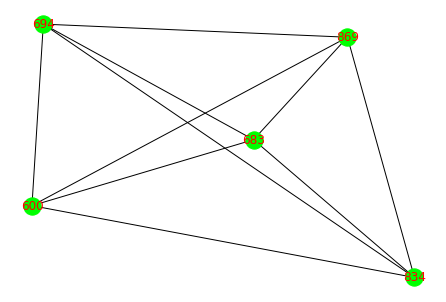

In [37]:
# draw a sample of the most common clique
most_common_clique = [clique for clique in cliques if len(clique) == most_common_size_of_clique]
nx.draw(undirected_G.subgraph(most_common_clique[0]), with_labels = True, node_color = "lime", font_color = "red")

## Most Popular Person

this person is in 217 number of clique, and here is a sample of his connections


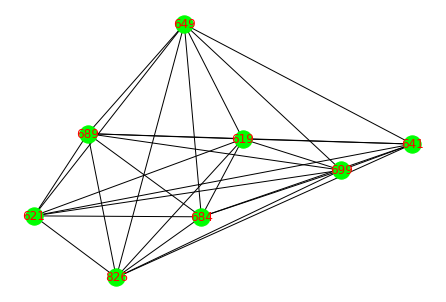

In [38]:
# draw a sample of network for the most popular person
most_popular_person = [clique for clique in cliques if most_popular_student in clique]
print('this person is in {x} number of clique, and here is a sample of his connections'.format(x = len(most_popular_person)))

nx.draw(undirected_G.subgraph(most_popular_person[0]), with_labels = True, node_color = "lime", font_color = "red")

## Shortest Path between the Most and Least Popular Persons

[826, 825, 856]


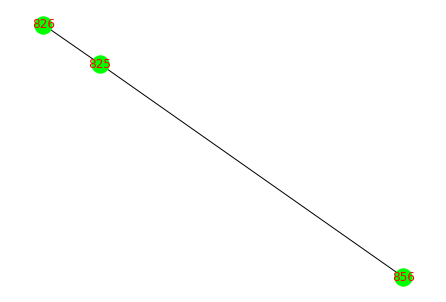

In [39]:
shortest_path = nx.shortest_path(undirected_G, most_popular_student, least_popular_student)

print(shortest_path)

nx.draw(undirected_G.subgraph(shortest_path), with_labels = True, node_color = "lime", font_color = "red")
